In [1]:
# 데이터 준비
from google.colab import files
uploaded = files.upload()

#파일 선택 눌러서 원하는 파일 가져오기 가능

# colab > run_project 폴더에 있는 colab_train_test.zip 파일을 선택합니다.
# 로컬 파일로 보내기
my_data = 'colab_train_test.zip'
!unzip colab_train_test.zip

Saving colab_train_test.zip to colab_train_test.zip
Archive:  colab_train_test.zip
   creating: test/ad/
  inflating: test/ad/ad_test_1.jpg   
  inflating: test/ad/ad_test_10.jpg  
  inflating: test/ad/ad_test_11.jpg  
  inflating: test/ad/ad_test_12.jpg  
  inflating: test/ad/ad_test_13.jpg  
  inflating: test/ad/ad_test_14.jpg  
  inflating: test/ad/ad_test_15.jpg  
  inflating: test/ad/ad_test_16.jpg  
  inflating: test/ad/ad_test_17.jpg  
  inflating: test/ad/ad_test_18.jpg  
  inflating: test/ad/ad_test_19.jpg  
  inflating: test/ad/ad_test_2.jpg   
  inflating: test/ad/ad_test_20.jpg  
  inflating: test/ad/ad_test_21.jpg  
  inflating: test/ad/ad_test_22.jpg  
  inflating: test/ad/ad_test_23.jpg  
  inflating: test/ad/ad_test_24.jpg  
  inflating: test/ad/ad_test_25.jpg  
  inflating: test/ad/ad_test_26.jpg  
  inflating: test/ad/ad_test_27.jpg  
  inflating: test/ad/ad_test_28.jpg  
  inflating: test/ad/ad_test_29.jpg  
  inflating: test/ad/ad_test_3.jpg   
  inflating: test/ad/

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

# 많이 사용하는 함수/ 디렉토리에서 이미지를 가지고오면서 증강. 하나하나 읽어온 후에 증강하는 대신에  (더 많이 사용하는 코드)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, initializers, regularizers, metrics

In [3]:
np.random.seed(3)
tf.random.set_seed(3)

# 이미지 데이터 생성기 만든 것
# 데이터 읽어오는 즉시 파라미터들 적용. 한장 읽어오는 과정에서 여러장이 된다
train_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True,     #수평 대칭 이미지를 50% 확률로 만들어 추가합니다.
                                  width_shift_range=0.1,  #전체 크기의 10% 범위에서 좌우로 이동합니다.
                                  height_shift_range=0.1, #마찬가지로 위, 아래로 이동합니다.
                                  #rotation_range=5,
                                  #shear_range=0.7,
                                  #zoom_range=[0.9, 2.2],
                                  #vertical_flip=True,     >> 이미지가 완전 대칭인 경우에는 의미 딱히 없어짐...
                                  fill_mode='nearest')

## 폴더 이름으로 y 피처를 만들어줌
train_generator = train_datagen.flow_from_directory(    # train_datagen을 거쳐서 가져오게 되는것
       'train',   #학습셋이 있는 폴더의 위치입니다. 디렉토리 이름
       target_size=(180, 180),
       batch_size=5,
       color_mode="rgb",
       class_mode='binary')

# 테스트 셋은 이미지 부풀리기 과정을 진행하지 않습니다.
# traingenerator 썼으면 test도 test_gen 똑같이 해줘야 한다. 그렇지만 test는 이미지 증강 안한다!!! 그래도 똑같이 해줘야한다는 것!!!
test_datagen = ImageDataGenerator(rescale=1./255)

## 폴더 이름으로 y 피처를 만들어줌
test_generator = test_datagen.flow_from_directory(
       'test',   #테스트셋이 있는 폴더의 위치입니다.
       target_size=(180, 180),
       batch_size=5,
       color_mode="rgb",
       class_mode='binary')

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [4]:
# 생성 가능한 배치 수
len(train_generator)

32

In [5]:
class_map = {
    0: 'AD',
    1: 'Normal',
}

(5, 180, 180, 3) (5,)
0.0


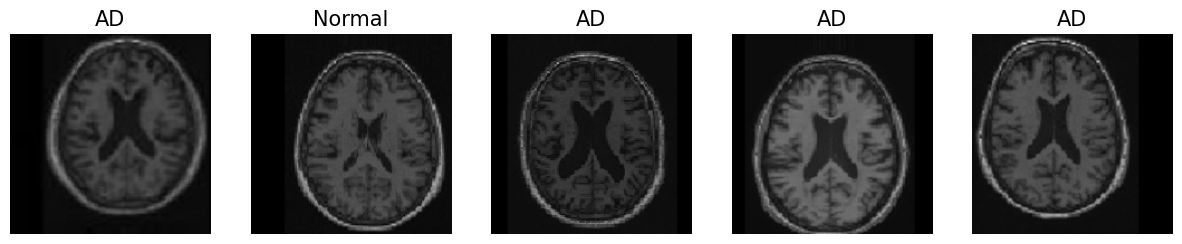

In [6]:
for x, y in train_generator:
    print(x.shape, y.shape)
    print(y[0])

    fig, axes = plt.subplots(1, 5)
    fig.set_size_inches(15, 15)
    for i in range(5):
        axes[i].imshow(x[i])
        axes[i].set_title(class_map[int(y[i])], fontsize=15)
        axes[i].axis('off')
    plt.show()
    break

# 모델 디자인

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers


conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",   #imagenet으로 학습한 가중치 사용
    include_top=False,    # 뒤파트를 top이라고 함. 뒤파트는 안가지고 오겠다는 뜻. 앞의 가중치만 쓰겠다.
    input_shape=(180, 180, 3))    # 여기까지 신경망 base모델
conv_base.summary() #모델 구조. 뒤부분 없어서 flatten층 dense층 .. 잘라서 없음 잘린 형태


#출력층 있어야하므로 flatten부터 붙이는것. 이진 분류니까 sigmoid
####모델
inputs = keras.Input(shape=(180, 180, 3))
x = conv_base(inputs)  # VGG16을 통한 특징 추출

x = layers.Conv2D(64, (3, 3), activation='relu')(x)  # Conv2D 추가
x = layers.Conv2D(32, (3, 3), activation='relu')(x)

# 마지막 Flatten, Dense 추가
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(2, activation='softmax')(x)  # 이진 분류


model = keras.Model(inputs, x)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])  # binary_crossentropy 해도 될것/ learning_rate 디폴트는 0.0001

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define model checkpoint to save the best model
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)


# 모델을 실행합니다
history = model.fit(
       train_generator,

       steps_per_epoch=32,  #적절한 값으로 조절
       epochs=8,   #적절한 값으로 조절
       validation_data=test_generator,
       validation_steps=10,
       callbacks=[early_stopping, model_checkpoint] # Add callbacks to the fit function
)


Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 235s 7s/step - accuracy: 0.3974 - loss: 0.7643 - val_accuracy: 0.5600 - val_loss: 0.6876
Epoch 2/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 262s 7s/step - accuracy: 0.5371 - loss: 0.7056 - val_accuracy: 0.6000 - val_loss: 0.6833
Epoch 3/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 262s 8s/step - accuracy: 0.5541 - loss: 0.6946 - val_accuracy: 0.5000 - val_loss: 0.7021
Epoch 4/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 263s 8s/step - accuracy: 0.4920 - loss: 0.7202 - val_accuracy: 0.5800 - val_loss: 0.6896
Epoch 5/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 320s 8s/step - accuracy: 0.5185 - loss: 0.7208 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 262s 8s/step - accuracy: 0.4614 - loss: 0.6997 - val_accuracy: 0.4800 - val_loss: 0.6932
Epoch 7/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 226s 7s/step - accuracy: 0.5147 - loss: 0.6975 - val_accuracy: 0.3800 - val_loss: 0.6961
Epoch 8/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 225s 7s/step - accuracy: 0.5237 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6929


In [9]:
# 성능 확인하기
# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(train_generator, steps=len(train_generator))
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5553 - loss: 0.6886
Training Accuracy: 50.00%
Training Loss: 0.6949
24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.4779 - loss: 0.6973
Test Accuracy: 50.00%
Test Loss: 0.6948


# LIME

In [10]:
# lime 진행

!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=8e2259f4414f2f1e943b4407c24097d60457c5c535ab5487d40a05f8abc80813
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

In [12]:
# 예측 함수 정의
def predict(input_img):
    input_img = preprocess_input(input_img)
    return model.predict(input_img)

In [14]:
from lime import lime_image

# test_generator에서 배치(batch)를 하나 가져옵니다.
batch_images, batch_labels = next(test_generator)

# 첫 번째 이미지에 대해 LIME을 적용
img = batch_images[0]  # 첫 번째 이미지를 선택

# 이미지 전처리 (필요한 전처리 작업: 0~1 범위로 스케일링)
img_array = img.astype('double')

# LIME 설명자 생성
explainer = lime_image.LimeImageExplainer()

# LIME 해석 수행
explanation = explainer.explain_instance(img_array,
                                         predict,  # 예측 함수
                                         top_labels=5,

                                         hide_color=0,  # 배경을 검정색으로
                                         num_samples=200)

# 특정 클래스에 대한 설명 시각화 (예측 상위 클래스 사용)
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    # temp는 LIME 설명 이미지, mask는 강조된 영역입니다.


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


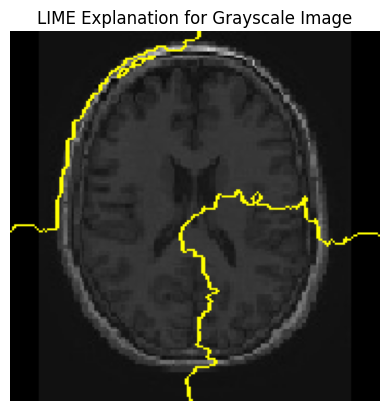

In [17]:
# 결과 시각화
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation for Grayscale Image")
plt.axis('off')
plt.show()
